In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# %matplotlib inline  # ako koristiš Jupyter, inače možeš ovo izostaviti

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import time
import seaborn as sns

In [29]:
#uvoz skupa podataka
df = pd.read_csv('../freMTPL2freq.csv')
df = df.sample(n=100000, random_state=42)
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
261354,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
448143,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
188618,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
12952,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
425028,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [30]:
df.shape

(100000, 12)

In [31]:
df.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [32]:
df.duplicated().sum() #nemamo duplikata u skupu

0

In [33]:
# izvaci redove gde je ClaimNb veca od 4
df = df[df['ClaimNb'] <= 4]

In [34]:
# Pretvaranje ciljne promenljive u binarnu (da li se desila šteta ili ne)
df["ClaimOccured"] = (df["ClaimNb"] > 0).astype(int)

In [35]:
# Izbacivanje identifikatora
df.drop(columns=["IDpol"], inplace=True)

In [36]:
# One-hot encoding za kategorijske varijable
df_encoded = pd.get_dummies(df)

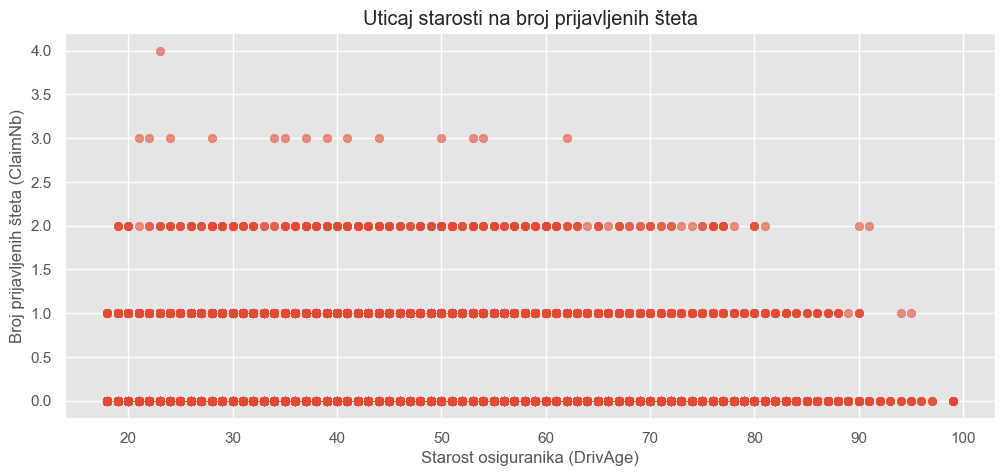

In [37]:
# Vizualizacija klastera

# Vizualizacija: Starost osiguranika vs Broj prijavljenih šteta
plt.figure(figsize=(12, 5))
plt.scatter(df['DrivAge'], df['ClaimNb'], alpha=0.6)
plt.xlabel('Starost osiguranika (DrivAge)')
plt.ylabel('Broj prijavljenih šteta (ClaimNb)')
plt.title('Uticaj starosti na broj prijavljenih šteta')
plt.show()

In [38]:
# Odabrane ključne karakteristike
#features = ['DrivAge', 'VehAge', 'ClaimNb', 'BonusMalus', 'VehPower', 'Density', 'Exposure']
#features = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'Exposure', 'BonusMalus', 'VehPower', 'BonusMalus', 'Area']

#X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
#X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])

In [39]:
# Ukloni IDpol i ClaimNb iz features
features = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'Exposure', 'BonusMalus', 'VehPower', 'BonusMalus', 'Area']

X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])

In [40]:

# Normalizacija podataka
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [41]:
# Definisanje raspona klastera
ks = range(2, 11)  # malo širi opseg da bolje vidi trendove

sse = []
sil_scores = []

# Izračunavanje SSE i Silhouette za svaki k
for k in ks:
    mbkmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42, batch_size=1000)
    mbkmeans.fit(x)
    sse.append(mbkmeans.inertia_)
    sil_scores.append(silhouette_score(x, mbkmeans.labels_))



In [42]:
# Pronalaženje optimalnog k na osnovu "elbow" (SSE)
kneedle = KneeLocator(ks, sse, curve='convex', direction='decreasing')
optimal_k_sse = kneedle.knee

# Pronalaženje optimalnog k na osnovu Silhouette
optimal_k_silhouette = ks[np.argmax(sil_scores)]

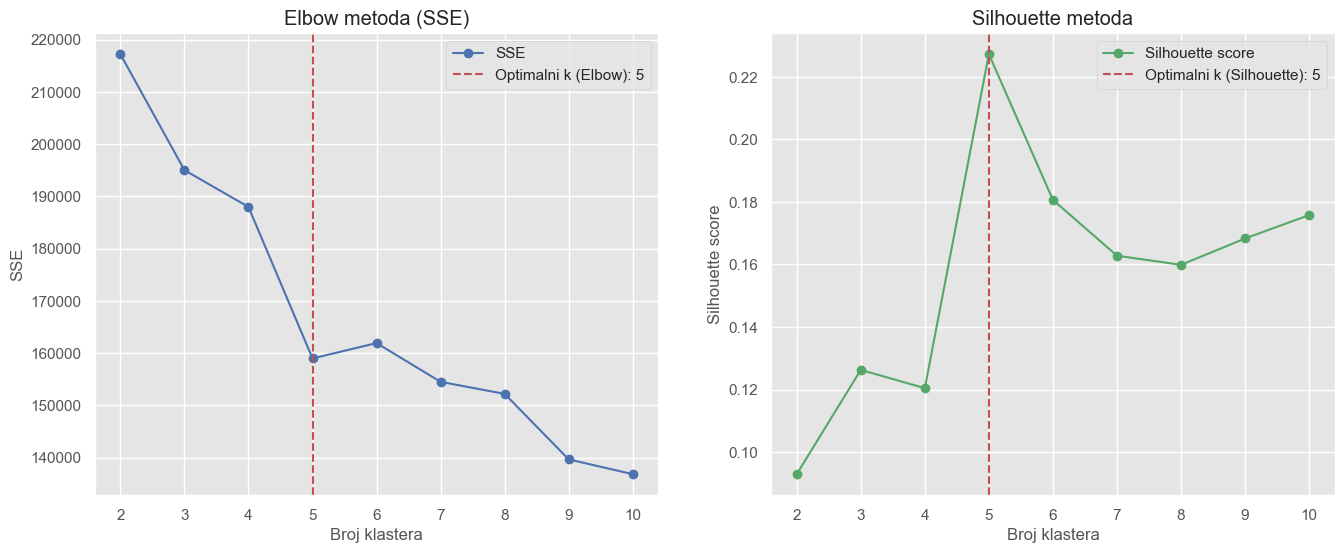

In [43]:
# Prikaz grafikona za SSE i Silhouette
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(ks, sse, 'bo-', label='SSE')
axs[0].axvline(optimal_k_sse, color='r', linestyle='--', label=f'Optimalni k (Elbow): {optimal_k_sse}')
axs[0].set_xlabel('Broj klastera')
axs[0].set_ylabel('SSE')
axs[0].set_title('Elbow metoda (SSE)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(ks, sil_scores, 'go-', label='Silhouette score')
axs[1].axvline(optimal_k_silhouette, color='r', linestyle='--', label=f'Optimalni k (Silhouette): {optimal_k_silhouette}')
axs[1].set_xlabel('Broj klastera')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Silhouette metoda')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [44]:
print(f"Optimalan broj klastera po Elbow (SSE) metodi: {optimal_k_sse}")
print(f"Optimalan broj klastera po Silhouette metodi: {optimal_k_silhouette}")

Optimalan broj klastera po Elbow (SSE) metodi: 5
Optimalan broj klastera po Silhouette metodi: 5


In [45]:
# Finalno klasterovanje sa optimalnim brojem klastera po Silhouette (možeš i po Elbow ako želiš)
kmeans = KMeans(n_clusters=optimal_k_silhouette, init='k-means++', n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(x)

In [46]:
# Vizualizacija klastera u 2D koristeći PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

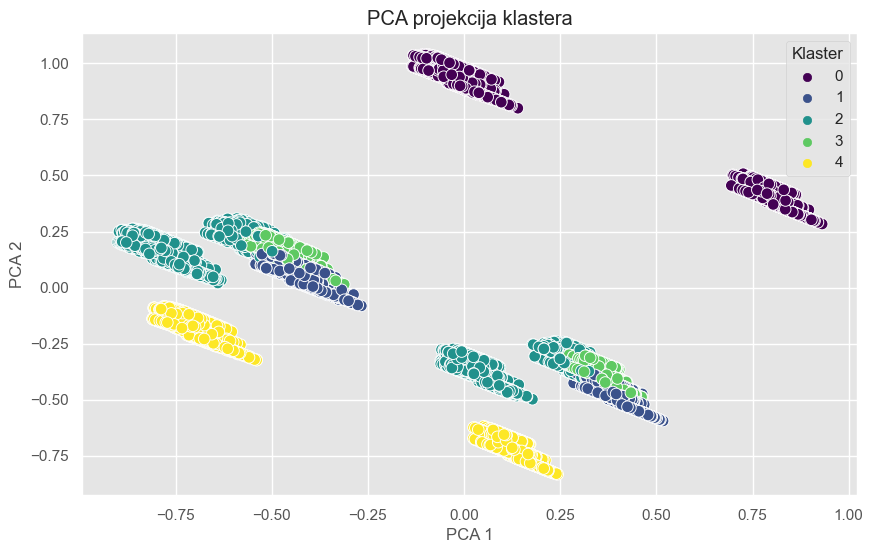

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=df['Cluster'], palette='viridis', s=70)
plt.title('PCA projekcija klastera')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Klaster')
plt.show()

In [48]:
for col in ['Area', 'VehBrand', 'VehGas', 'Region']:
    df[col] = df[col].astype('category')

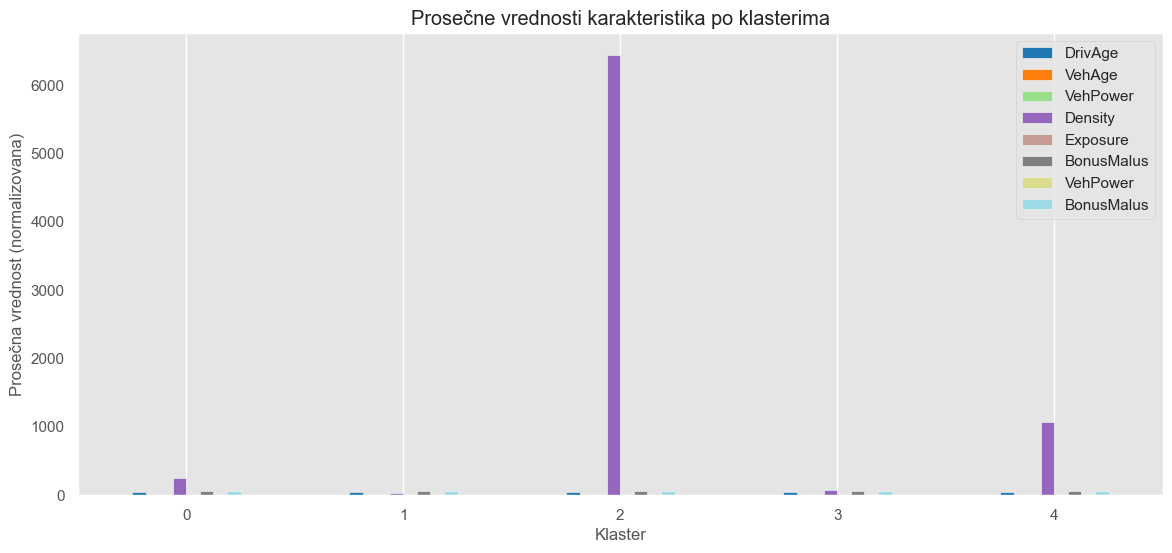

In [49]:
# Analiza prosečnih vrednosti po klasterima
numeric_features = df[features].select_dtypes(include='number').columns

cluster_means = df.groupby('Cluster')[numeric_features].mean()
cluster_means.plot(kind='bar', figsize=(14, 6), colormap='tab20')
plt.title('Prosečne vrednosti karakteristika po klasterima')
plt.xlabel('Klaster')
plt.ylabel('Prosečna vrednost (normalizovana)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

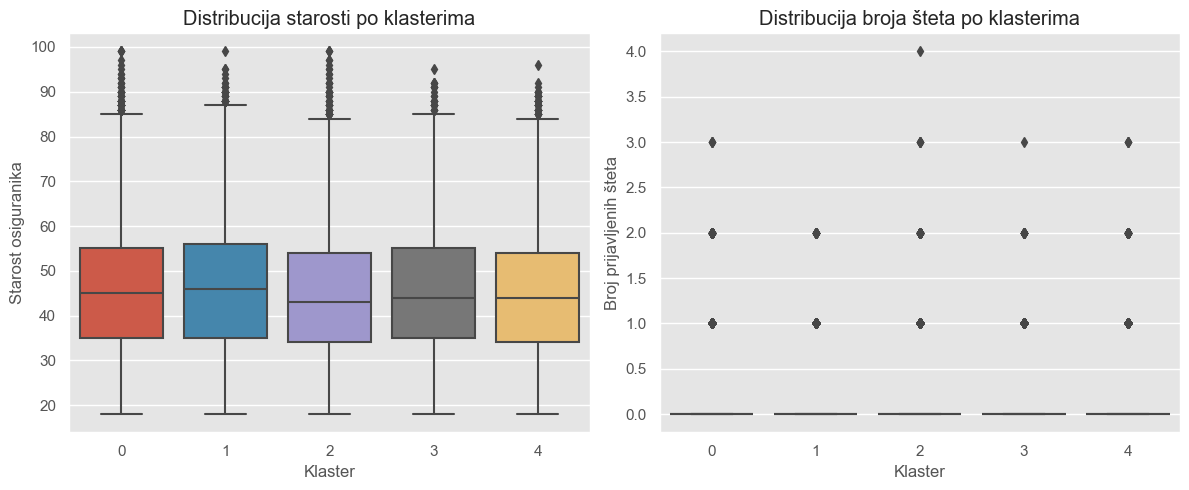

In [50]:
# Distribucija starosti i broja šteta po klasterima
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='DrivAge', data=df)
plt.title('Distribucija starosti po klasterima')
plt.xlabel('Klaster')
plt.ylabel('Starost osiguranika')

plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='ClaimNb', data=df)
plt.title('Distribucija broja šteta po klasterima')
plt.xlabel('Klaster')
plt.ylabel('Broj prijavljenih šteta')

plt.tight_layout()
plt.show()

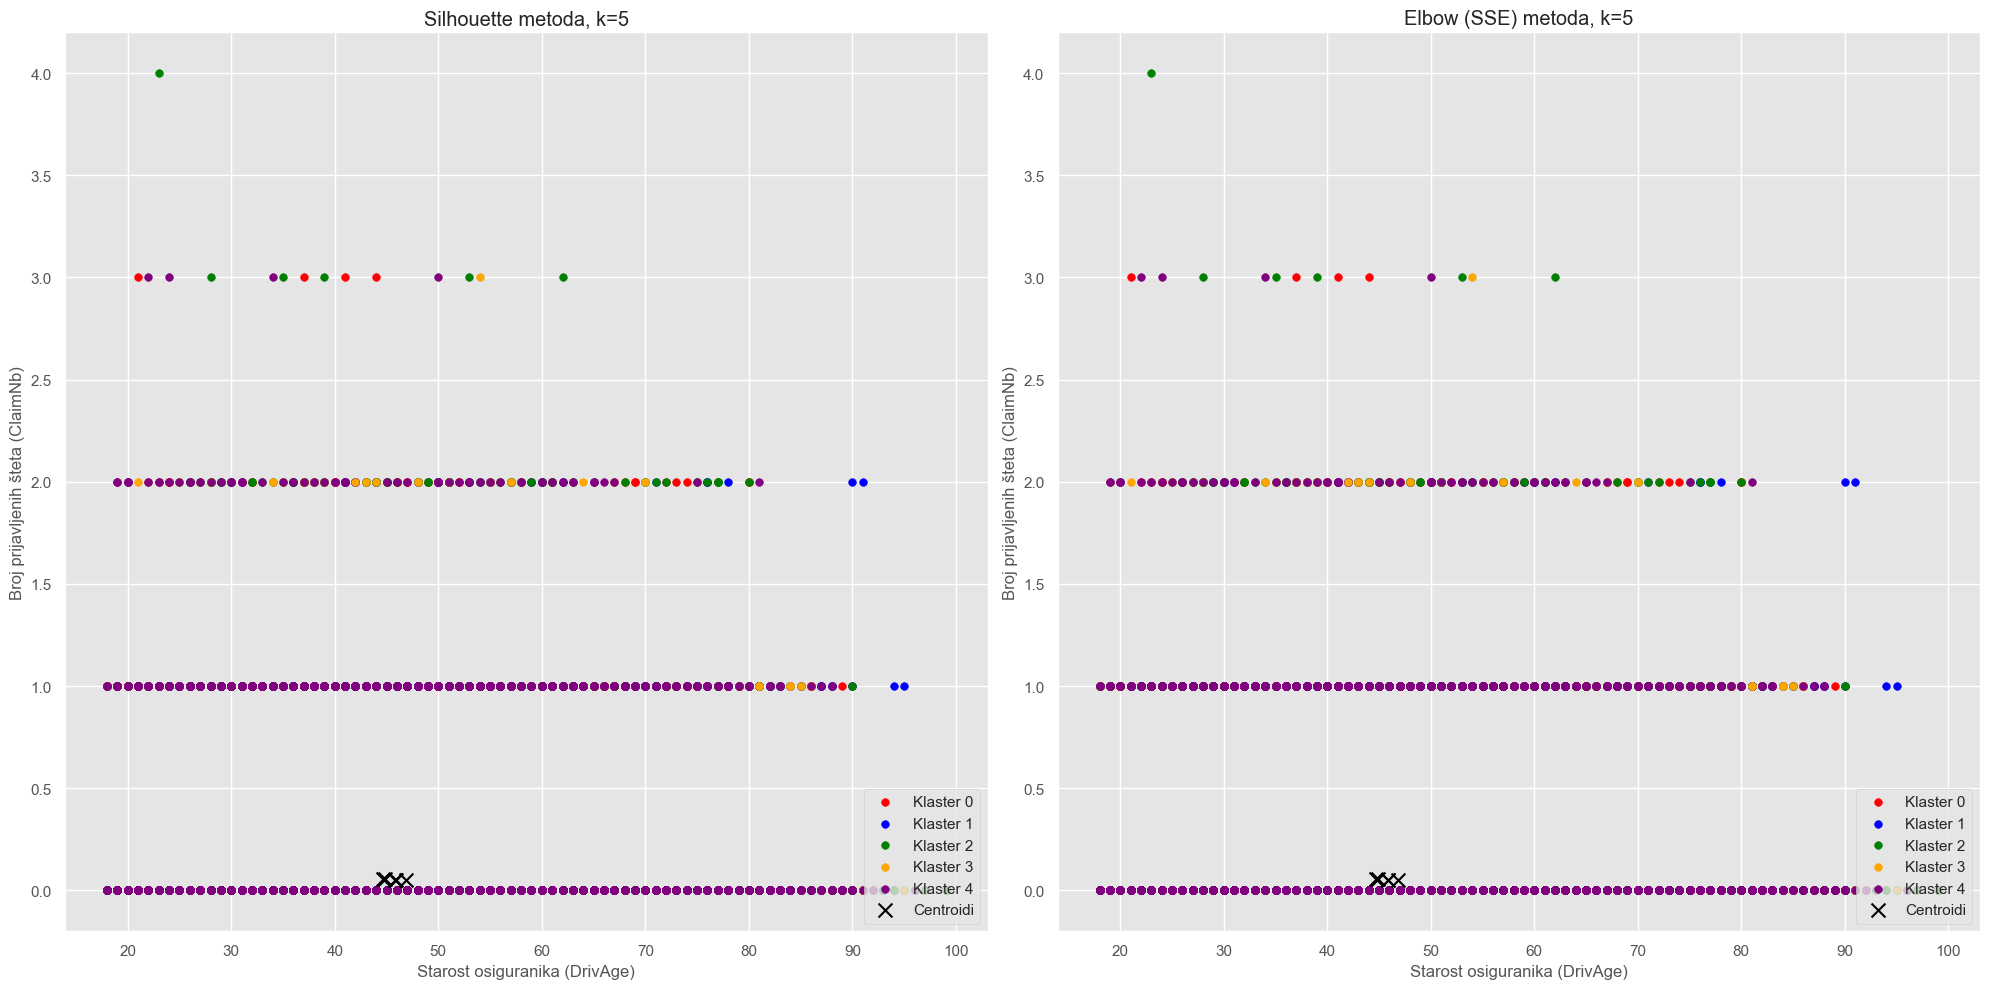

In [51]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
features_x = x.columns.tolist()

# K-means Silhouette
k_sil = optimal_k_silhouette
kmeans_sil = KMeans(n_clusters=k_sil, init='k-means++', n_init=10, random_state=42)
df['Cluster_Silhouette'] = kmeans_sil.fit_predict(x)
centers_sil = pd.DataFrame(scaler.inverse_transform(kmeans_sil.cluster_centers_), columns=features_x)

# Prosečne vrednosti ClaimNb po klasterima Silhouette
claimnb_means_sil = df.groupby('Cluster_Silhouette')['ClaimNb'].mean()

for j in range(k_sil):
    cluster = df[df['Cluster_Silhouette'] == j]
    axs[0].scatter(cluster['DrivAge'], cluster['ClaimNb'], color=colors[j], s=30, marker='o', label=f"Klaster {j}")

# Crtaj centroid samo za DrivAge (iz centara skaliranih vrednosti) i za ClaimNb koristi proseke
axs[0].scatter(centers_sil['DrivAge'], claimnb_means_sil, color='black', marker='x', s=100, label='Centroidi')
axs[0].set_title(f'Silhouette metoda, k={k_sil}')
axs[0].set_xlabel('Starost osiguranika (DrivAge)')
axs[0].set_ylabel('Broj prijavljenih šteta (ClaimNb)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# K-means SSE (Elbow)
k_sse = optimal_k_sse
kmeans_sse = KMeans(n_clusters=k_sse, init='k-means++', n_init=10, random_state=42)
df['Cluster_SSE'] = kmeans_sse.fit_predict(x)
centers_sse = pd.DataFrame(scaler.inverse_transform(kmeans_sse.cluster_centers_), columns=features_x)

# Prosečne vrednosti ClaimNb po klasterima SSE
claimnb_means_sse = df.groupby('Cluster_SSE')['ClaimNb'].mean()

for j in range(k_sse):
    cluster = df[df['Cluster_SSE'] == j]
    axs[1].scatter(cluster['DrivAge'], cluster['ClaimNb'], color=colors[j], s=30, marker='o', label=f"Klaster {j}")

axs[1].scatter(centers_sse['DrivAge'], claimnb_means_sse, color='black', marker='x', s=100, label='Centroidi')
axs[1].set_title(f'Elbow (SSE) metoda, k={k_sse}')
axs[1].set_xlabel('Starost osiguranika (DrivAge)')
axs[1].set_ylabel('Broj prijavljenih šteta (ClaimNb)')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.tight_layout()
plt.show()


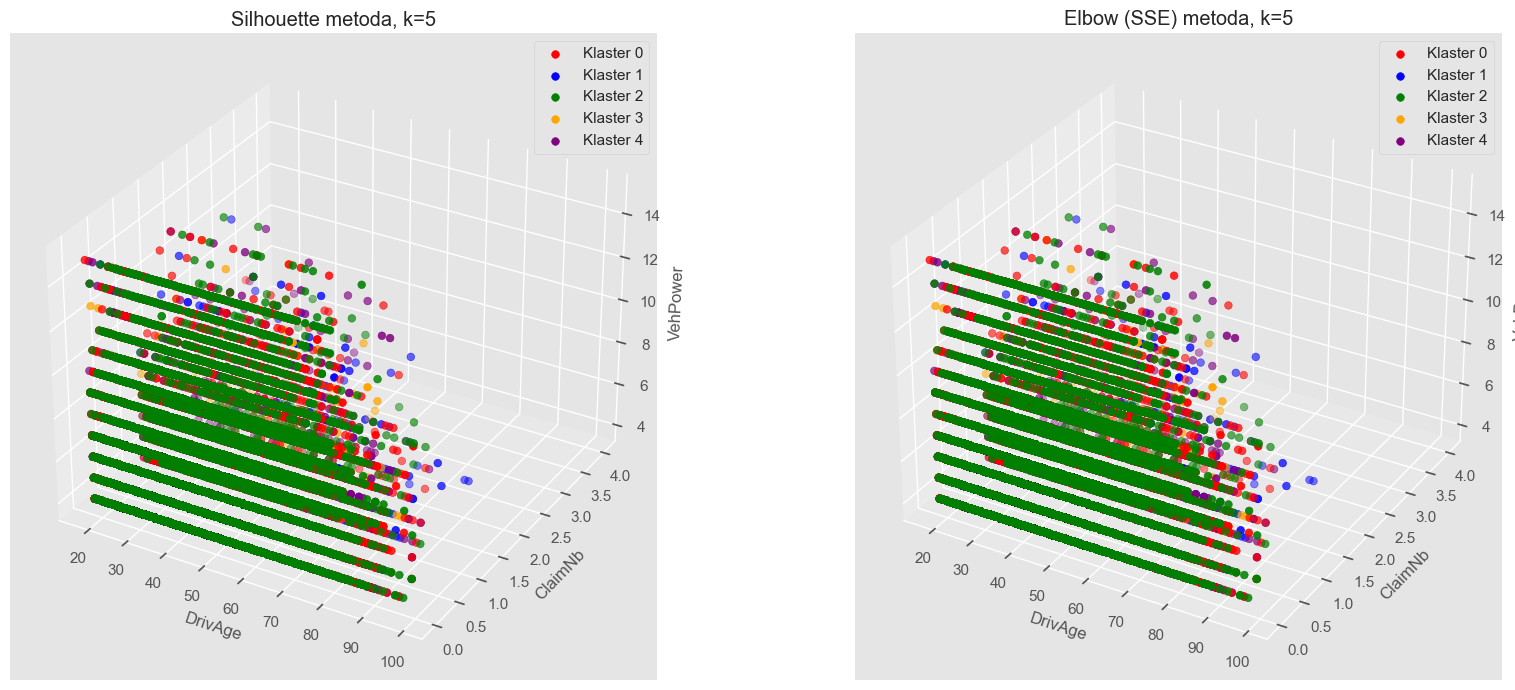

In [52]:
#  Prikaz klastera u 3D prostoru
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121, projection='3d')
colors = ['red', 'blue', 'green', 'orange', 'purple',  'yellow']  # po potrebi dodaj još boja

for j in range(optimal_k_silhouette):
    cluster = df[df['Cluster_Silhouette'] == j]
    ax1.scatter(cluster['DrivAge'], cluster['ClaimNb'], cluster['VehPower'], 
                color=colors[j], s=30, label=f"Klaster {j}")

ax1.set_title(f'Silhouette metoda, k={k_sil}')
ax1.set_xlabel('DrivAge')
ax1.set_ylabel('ClaimNb')
ax1.set_zlabel('VehPower')
ax1.legend()

# 3D prikaz za SSE (Elbow) metodu
ax2 = fig.add_subplot(122, projection='3d')

for j in range(optimal_k_sse):
    cluster = df[df['Cluster_SSE'] == j]
    ax2.scatter(cluster['DrivAge'], cluster['ClaimNb'], cluster['VehPower'], 
                color=colors[j], s=30, label=f"Klaster {j}")

ax2.set_title(f'Elbow (SSE) metoda, k={k_sse}')
ax2.set_xlabel('DrivAge')
ax2.set_ylabel('ClaimNb')
ax2.set_zlabel('VehPower')
ax2.legend()

plt.tight_layout()
plt.show()

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

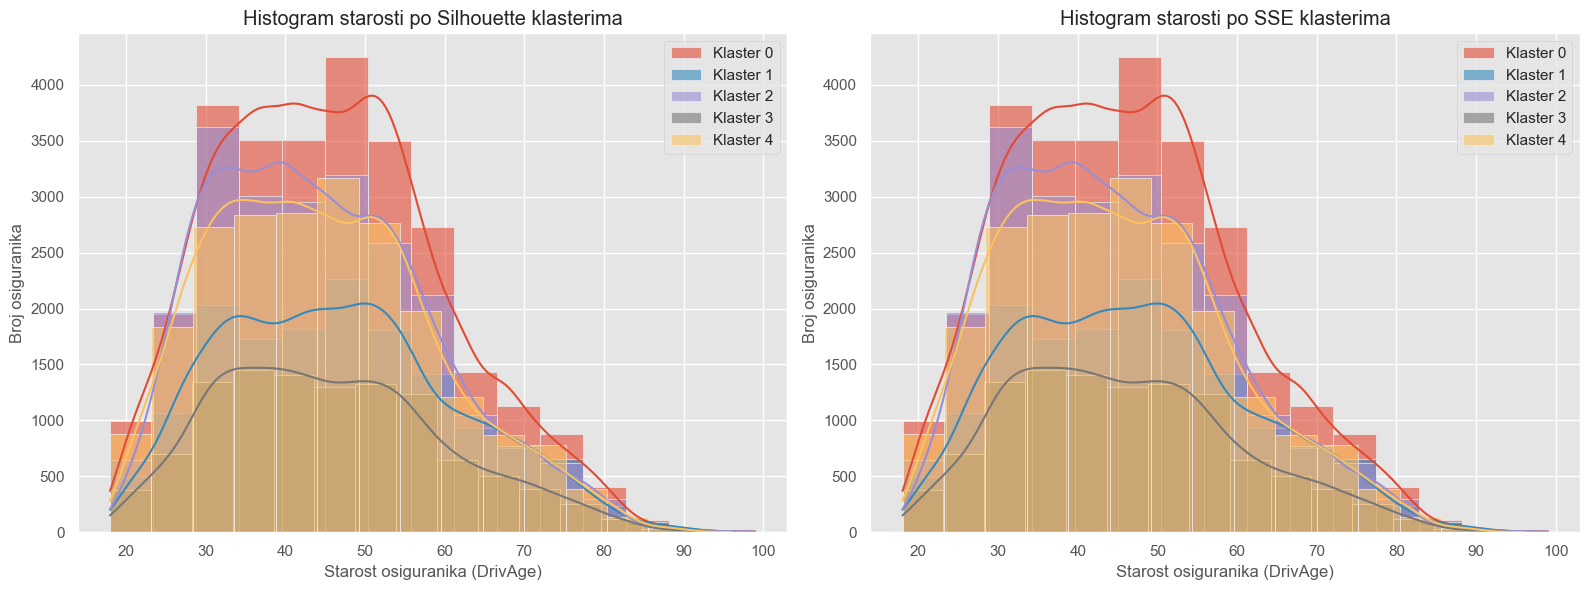

In [53]:
# Histogram starosti osiguranika po klasterima

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Histogram za Silhouette klastere
for j in range(optimal_k_silhouette):
    subset = df[df['Cluster_Silhouette'] == j]
    sns.histplot(subset['DrivAge'], label=f'Klaster {j}', kde=True, bins=15, alpha=0.6, ax=axs[0])

axs[0].set_title('Histogram starosti po Silhouette klasterima')
axs[0].set_xlabel('Starost osiguranika (DrivAge)')
axs[0].set_ylabel('Broj osiguranika')
axs[0].legend()

# Histogram za SSE klastere
for j in range(optimal_k_sse):
    subset = df[df['Cluster_SSE'] == j]
    sns.histplot(subset['DrivAge'], label=f'Klaster {j}', kde=True, bins=15, alpha=0.6, ax=axs[1])

axs[1].set_title('Histogram starosti po SSE klasterima')
axs[1].set_xlabel('Starost osiguranika (DrivAge)')
axs[1].set_ylabel('Broj osiguranika')
axs[1].legend()

plt.tight_layout()
plt.show()

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

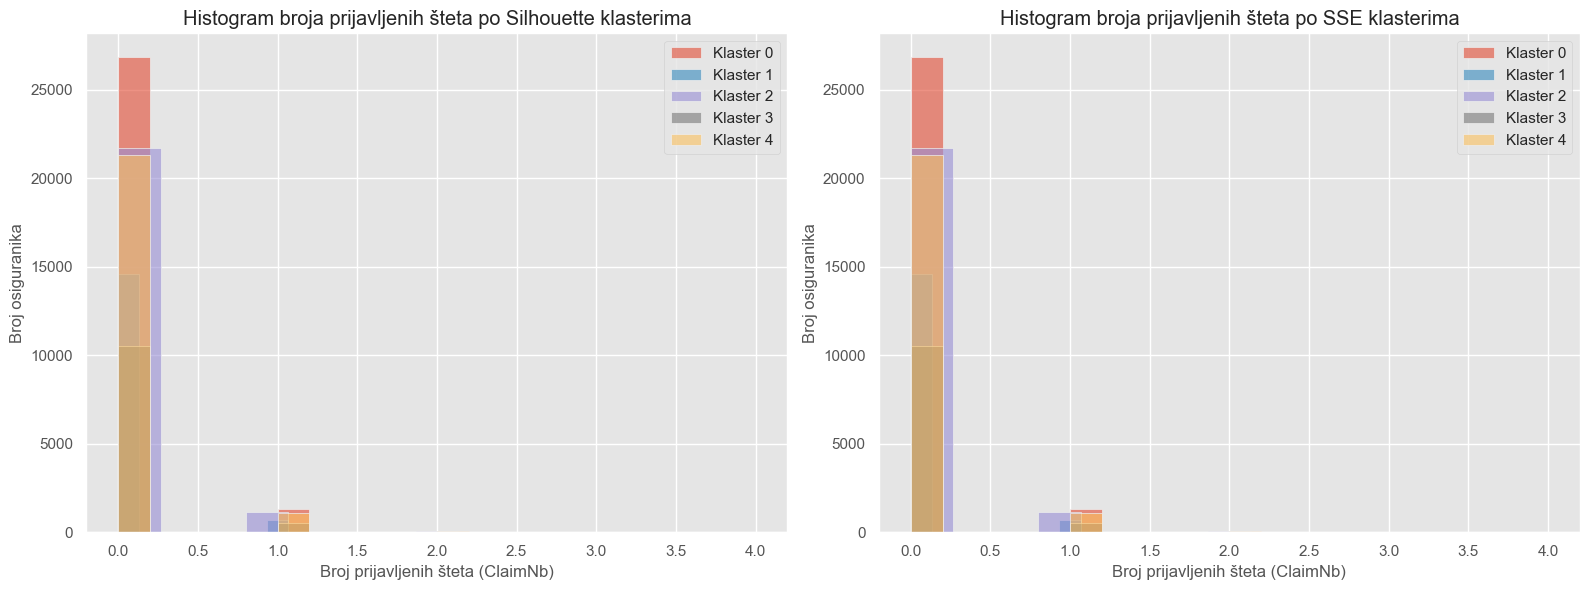

In [54]:
#  Histogram broja prijavljenih šteta po klasterima

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Histogram za Silhouette klastere
for j in range(optimal_k_silhouette):
    subset = df[df['Cluster_Silhouette'] == j]
    sns.histplot(subset['ClaimNb'], label=f'Klaster {j}', kde=False, bins=15, alpha=0.6, ax=axs[0])

axs[0].set_title('Histogram broja prijavljenih šteta po Silhouette klasterima')
axs[0].set_xlabel('Broj prijavljenih šteta (ClaimNb)')
axs[0].set_ylabel('Broj osiguranika')
axs[0].legend()

# Histogram za SSE klastere
for j in range(optimal_k_sse):
    subset = df[df['Cluster_SSE'] == j]
    sns.histplot(subset['ClaimNb'], label=f'Klaster {j}', kde=False, bins=15, alpha=0.6, ax=axs[1])

axs[1].set_title('Histogram broja prijavljenih šteta po SSE klasterima')
axs[1].set_xlabel('Broj prijavljenih šteta (ClaimNb)')
axs[1].set_ylabel('Broj osiguranika')
axs[1].legend()

plt.tight_layout()
plt.show()

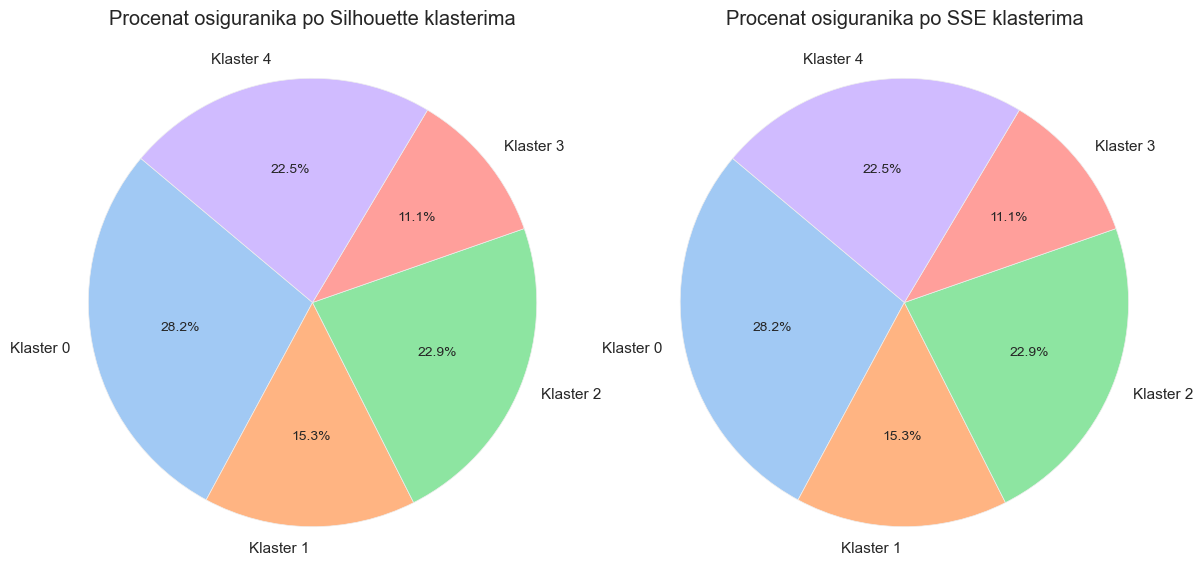

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart za Silhouette klastere
cluster_counts_sil = df['Cluster_Silhouette'].value_counts().sort_index()
axs[0].pie(cluster_counts_sil, labels=[f'Klaster {i}' for i in cluster_counts_sil.index], 
           autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts_sil)))
axs[0].set_title('Procenat osiguranika po Silhouette klasterima')
axs[0].axis('equal')

# Pie chart za SSE klastere
cluster_counts_sse = df['Cluster_SSE'].value_counts().sort_index()
axs[1].pie(cluster_counts_sse, labels=[f'Klaster {i}' for i in cluster_counts_sse.index], 
           autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts_sse)))
axs[1].set_title('Procenat osiguranika po SSE klasterima')
axs[1].axis('equal')

plt.show()